In [1]:
import pandas as pd
import glob
import os

# 1. 시트별 경로 정의
table_paths = {
    "1.회원정보": "data/train/1.회원정보",
    "4.청구입금정보": "data/train/4.청구입금정보"
}

# 2. 데이터 불러오기
merged_data = {}

for name, path in table_paths.items():
    files = glob.glob(os.path.join(path, "*.parquet"))
    if len(files) > 0:
        df = pd.concat([pd.read_parquet(f) for f in sorted(files)], ignore_index=True)
        merged_data[name] = df
        print(f"{name} ✅ 불러오기 완료: {df.shape}")
    else:
        print(f"{name} ⚠️ 파일 없음")

# 3. 필요한 데이터 추출 및 병합
member_df = merged_data["1.회원정보"]
bill_df = merged_data["4.청구입금정보"]

# ID, Segment만 추출
segment_df = member_df[['ID', 'Segment']].drop_duplicates(subset='ID')

# ID 기준 병합
bill_df_with_segment = pd.merge(bill_df, segment_df, on='ID', how='left')

# 4. 병합 결과 확인
print(f"병합 후 행 수: {len(bill_df_with_segment)}")
print(f"Segment 컬럼 결측치 수: {bill_df_with_segment['Segment'].isnull().sum()}")

# 5. CSV 파일로 저장
save_path = "data/청구입금정보_with_segment.csv"
bill_df_with_segment.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"📁 CSV 저장 완료: {save_path}")


1.회원정보 ✅ 불러오기 완료: (2400000, 78)
4.청구입금정보 ✅ 불러오기 완료: (2400000, 46)
병합 후 행 수: 2400000
Segment 컬럼 결측치 수: 0
📁 CSV 저장 완료: data/청구입금정보_with_segment.csv


In [3]:
bill_df_with_segment = pd.read_csv("data/청구입금정보_with_segment.csv")

In [5]:
bill_df_with_segment

,기준년월,ID,대표결제일,대표결제방법코드,대표청구지고객주소구분코드,대표청구서수령지구분코드,청구서수령방법,청구서발송여부_B0,청구서발송여부_R3M,청구서발송여부_R6M,...,상환개월수_결제일_R6M,상환개월수_결제일_R3M,선결제건수_R6M,선결제건수_R3M,연체건수_R6M,연체건수_R3M,혜택수혜금액_R3M,포인트_마일리지_환산_B0M,혜택수혜금액,Segment
0,201807,TRAIN_000000,27,자동이체,미확인,당사페이앱+이메일,문자메세지,1,1,1,...,5,3,0,0,1,0,3,0,0,D
1,201807,TRAIN_000001,13,자동이체,주거지,우편,우편,1,1,1,...,6,3,0,0,0,0,0,0,0,E
2,201807,TRAIN_000002,1,자동이체,미확인,이메일,이메일,1,1,1,...,6,3,0,0,0,0,121,0,50,C
3,201807,TRAIN_000003,5,자동이체,주거지,우편,우편,1,1,1,...,5,3,2,0,0,0,3,0,2,D
4,201807,TRAIN_000004,13,자동이체,주거지,우편,우편,0,1,1,...,1,1,0,0,0,0,0,0,0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,201812,TRAIN_399995,25,자동이체,주거지,우편,우편,0,0,0,...,0,0,0,0,0,0,0,0,0,E
2399996,201812,TRAIN_399996,20,자동이체,미확인,이메일,이메일,1,1,1,...,6,3,0,0,0,0,164,0,53,D
2399997,201812,TRAIN_399997,20,자동이체,회사,우편,우편,1,1,1,...,6,3,0,0,0,0,0,0,0,C
2399998,201812,TRAIN_399998,20,자동이체,주거지,우편,우편,0,0,0,...,0,0,0,0,0,0,0,0,0,E


### 포인트 관련 변수, 기간별 살펴보기

In [13]:
# 포인트 관련 B0M 컬럼만 추출
point_b0m_columns = [
    col for col in bill_df.columns
    if col.startswith("포인트") and col.endswith("B0M")
]

print("📌 '포인트' B0M 관련 컬럼:")
for col in point_b0m_columns:
    print("-", col)

# 데이터프레임 생성 (Segment 포함)
point_b0m_df = bill_df_with_segment[["Segment"] + point_b0m_columns]

📌 '포인트' B0M 관련 컬럼:
- 포인트_마일리지_건별_B0M
- 포인트_포인트_건별_B0M
- 포인트_마일리지_월적립_B0M
- 포인트_포인트_월적립_B0M
- 포인트_잔여포인트_B0M
- 포인트_마일리지_환산_B0M


In [20]:
# Segment A~E 대상만 필터링
point_b0m_ab = bill_df_with_segment[bill_df_with_segment['Segment'].isin(['A', 'B', 'C', 'D', 'E'])]

# 세그먼트별 평균 계산 후 전치
ab_point_b0m_mean = point_b0m_ab.groupby("Segment")[point_b0m_columns].mean().T

# 보기 좋게 출력
from IPython.display import display
display(ab_point_b0m_mean)

Segment,A,B,C,D,E
포인트_마일리지_건별_B0M,565.255144,605.618056,198.764809,85.482107,15.493310
포인트_포인트_건별_B0M,806.450617,1005.215278,573.756768,470.561822,198.627945
포인트_마일리지_월적립_B0M,327.611111,132.138889,77.168924,32.029742,7.462530
포인트_포인트_월적립_B0M,72.069959,706.493056,699.905071,532.889827,92.626900
포인트_잔여포인트_B0M,0.000000,0.000000,0.367787,0.454934,0.569952
포인트_마일리지_환산_B0M,166.079218,144.319444,47.385093,18.418280,3.317071


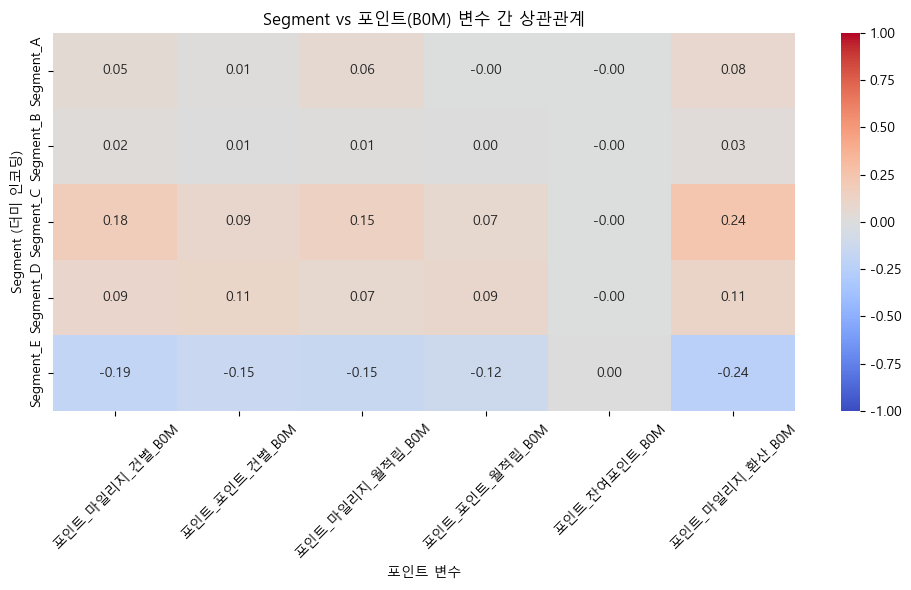

In [22]:
# Segment를 더미 인코딩
df_corr = bill_df_with_segment.copy()
segment_dummies = pd.get_dummies(df_corr["Segment"], prefix="Segment")
df_corr = pd.concat([df_corr, segment_dummies], axis=1)

# 상관관계 분석 대상 변수: Segment_* 와 point_b0m_columns
corr_columns = [col for col in df_corr.columns if col.startswith("Segment_")] + point_b0m_columns

# 상관계수 계산
corr_matrix = df_corr[corr_columns].corr()

# 상관관계 시각화 (Segment_* vs 포인트만 필터)
segment_corr = corr_matrix.loc[
    [col for col in corr_matrix.index if col.startswith("Segment_")],
    point_b0m_columns
]

# 히트맵 그리기
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(segment_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmax=1, vmin=-1)
plt.title("Segment vs 포인트(B0M) 변수 간 상관관계")
plt.xlabel("포인트 변수")
plt.ylabel("Segment (더미 인코딩)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 💳 Segment별 포인트(B0M) 분석 요약

#### ✅ 세그먼트별 평균값 분석 (B0M 기준)

- **Segment A, B**
  - 대부분 포인트 및 마일리지 관련 항목에서 높은 수치를 보임
  - 다만, 수치가 높은 것에 비해 세그먼트 구분력(상관관계)은 크지 않음

- **Segment C, D**
  - 일부 항목에서 중간 이상 수치를 보이며, 포인트 관련 항목과 **약한 양의 상관관계** 확인됨 (0.07~0.24)

- **Segment E**
  - 대부분 항목에서 포인트 수치가 낮고, 상관관계 또한 음(-)으로 나타남
  - 특히 `포인트_마일리지_환산_B0M`, `포인트_포인트_월적립_B0M` 항목과 **강한 음의 상관관계**를 보여줌
  - 잔여포인트는 오히려 E에서 가장 높음 → **포인트 적립 후 사용하지 않는 패턴**

---

#### 🧩 인사이트 요약

- **포인트 변수는 Segment E 식별에 효과적**
- A/B 그룹은 수치가 높지만 예측력은 낮은 편
- R3M, R12M 데이터를 추가적으로 비교해보며 **누적 포인트의 영향력**을 점검할 필요 있음


In [25]:
# 1. R3M & R12M 포인트 변수만 추출
point_r3m_columns = [col for col in bill_df_with_segment.columns if col.startswith("포인트") and "R3M" in col]
point_r12m_columns = [col for col in bill_df_with_segment.columns if col.startswith("포인트") and "R12M" in col]

# 2. Segment A~E만 필터링
point_df_ab = bill_df_with_segment[bill_df_with_segment['Segment'].isin(['A', 'B', 'C', 'D', 'E'])]

# 3. 평균값 전치 출력
from IPython.display import display

# R3M 평균
r3m_mean = point_df_ab.groupby("Segment")[point_r3m_columns].mean().T
print("📊 Segment별 포인트 (R3M) 평균")
display(r3m_mean)

# R12M 평균
r12m_mean = point_df_ab.groupby("Segment")[point_r12m_columns].mean().T
print("📊 Segment별 포인트 (R12M) 평균")
display(r12m_mean)

📊 Segment별 포인트 (R3M) 평균


Segment,A,B,C,D,E
포인트_마일리지_건별_R3M,1685.144033,1807.909722,583.698754,248.134795,44.378043
포인트_포인트_건별_R3M,2322.020576,2837.687500,1660.877341,1355.037997,559.545157
포인트_마일리지_월적립_R3M,1071.596708,430.930556,241.867153,98.777587,22.928668
포인트_포인트_월적립_R3M,321.103909,2231.090278,1859.631154,1493.110113,352.013396
포인트_적립포인트_R3M,2634.699588,4792.416667,2983.222894,2578.174389,958.112157
포인트_이용포인트_R3M,3609.936214,9080.715278,5144.311184,4248.117397,1368.394114


📊 Segment별 포인트 (R12M) 평균


Segment,A,B,C,D,E
포인트_적립포인트_R12M,9303.530864,13768.902778,8163.578501,6492.180540,2084.889276
포인트_이용포인트_R12M,19014.758230,64764.729167,29266.219139,24082.708194,6760.676666


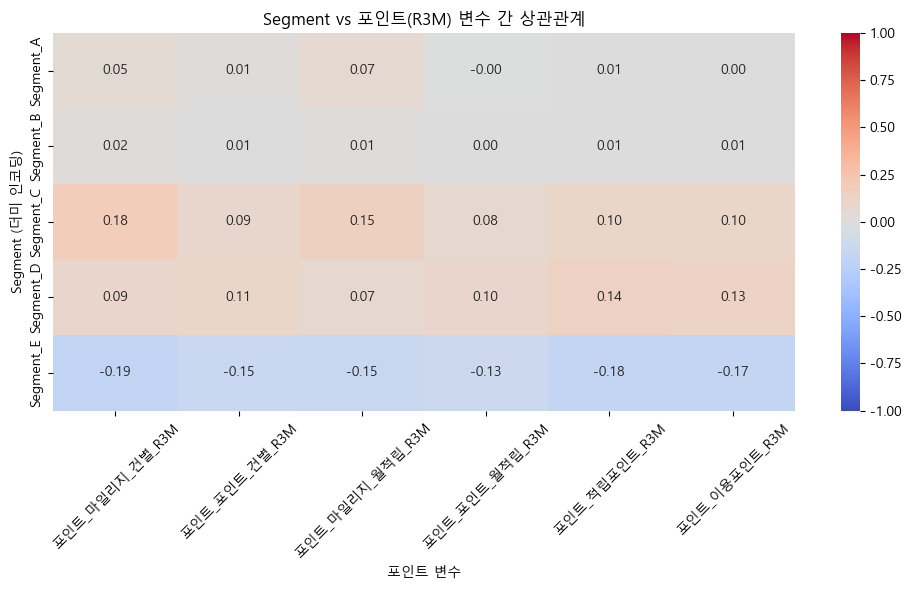

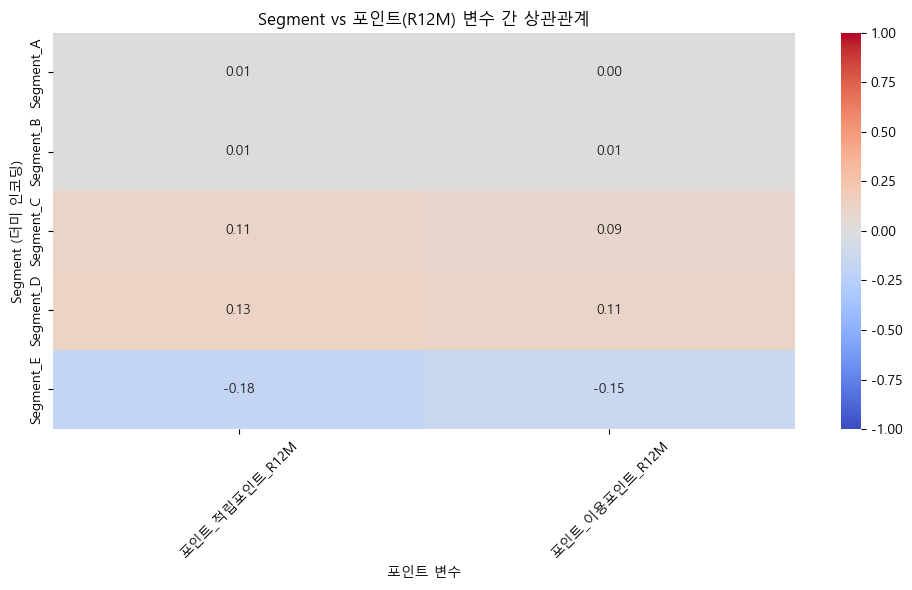

In [27]:
# 더미 인코딩
df_corr = bill_df_with_segment.copy()
segment_dummies = pd.get_dummies(df_corr["Segment"], prefix="Segment")
df_corr = pd.concat([df_corr, segment_dummies], axis=1)

# 상관관계 계산
corr_cols_r3m = [col for col in df_corr.columns if col in point_r3m_columns] + list(segment_dummies.columns)
corr_cols_r12m = [col for col in df_corr.columns if col in point_r12m_columns] + list(segment_dummies.columns)

# R3M 상관관계
r3m_corr = df_corr[corr_cols_r3m].corr()
r3m_corr_seg = r3m_corr.loc[segment_dummies.columns, point_r3m_columns]

# R12M 상관관계
r12m_corr = df_corr[corr_cols_r12m].corr()
r12m_corr_seg = r12m_corr.loc[segment_dummies.columns, point_r12m_columns]

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

def plot_segment_corr(corr_df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmax=1, vmin=-1)
    plt.title(title)
    plt.xlabel("포인트 변수")
    plt.ylabel("Segment (더미 인코딩)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_segment_corr(r3m_corr_seg, "Segment vs 포인트(R3M) 변수 간 상관관계")
plot_segment_corr(r12m_corr_seg, "Segment vs 포인트(R12M) 변수 간 상관관계")

### 🧾 Segment별 포인트(R3M & R12M) 변수 분석 요약

#### ✅ 평균값 비교 결과

- **Segment A, B**:  
  - 모든 포인트 관련 항목에서 **압도적으로 높은 평균값**을 보임  
  - 특히 R12M 기준 `이용포인트` 항목은 Segment B에서 64,764 이상으로 매우 큼 → **사용 경험이 많은 고객**

- **Segment C, D**:  
  - 포인트 및 마일리지 수치는 A, B보다는 낮지만 **중간 수준 이상**
  - 특히 `포인트_포인트_월적립_R3M`, `포인트_적립포인트_R3M` 항목 등은 세그먼트 구분에 일부 기여할 가능성 존재

- **Segment E**:  
  - 전반적으로 **가장 낮은 수치**  
  - 누적(R3M, R12M) 기준 포인트 활용량도 적고, 포인트 사용 빈도 또한 낮음
  - → **비활성 고객 또는 저가치 고객군 가능성**

---

#### 🔍 인사이트 및 판단

- 포인트 변수는 전체적으로 **세그먼트 간 분포 차이가 뚜렷**하게 존재  
- 특히 **누적(R3M, R12M) 기준 변수는 예측에 유의미한 특징 변수**로 활용 가능성 높음
- 다중공선성이나 유사한 변수 제거는 추후 VIF, PCA 등으로 판단 가능  
- 지금 단계에서는 **해당 변수들을 유지하고 진행**하는 것이 타당함 ✅

> 🔖 추천: 이후 모델링 단계에서 변수 중요도/상관성 기준으로 선택적 제거 고려


### 마일리지

In [30]:
# 컬럼 이름 기준 필터링
mile_columns = [col for col in bill_df_with_segment.columns if col.startswith("마일_")]

# 그룹핑
mile_b0m_cols = [col for col in mile_columns if "_B0M" in col]
mile_r3m_cols = [col for col in mile_columns if "_R3M" in col]
mile_r12m_cols = [col for col in mile_columns if "_R12M" in col]

In [33]:
def segment_mean_by_cols(df, cols):
    # A~E Segment만 필터
    df_seg = df[df['Segment'].isin(['A', 'B', 'C', 'D', 'E'])]
    
    # 세그먼트별 평균 계산 후 전치
    return df_seg.groupby("Segment")[cols].mean().T

In [35]:
from IPython.display import display

# B0M
print("📊 Segment별 마일(B0M) 평균")
display(segment_mean_by_cols(bill_df_with_segment, mile_b0m_cols))

# R3M
print("📊 Segment별 마일(R3M) 평균")
display(segment_mean_by_cols(bill_df_with_segment, mile_r3m_cols))

# R12M
print("📊 Segment별 마일(R12M) 평균")
display(segment_mean_by_cols(bill_df_with_segment, mile_r12m_cols))

📊 Segment별 마일(B0M) 평균


Segment,A,B,C,D,E
마일_잔여포인트_B0M,355.927984,129.756944,82.064143,34.727163,8.382309


📊 Segment별 마일(R3M) 평균


Segment,A,B,C,D,E
마일_적립포인트_R3M,2915.158436,2302.034722,831.908277,340.496684,65.235116
마일_이용포인트_R3M,1560.997942,1722.784722,548.579128,235.629145,42.945696


📊 Segment별 마일(R12M) 평균


Segment,A,B,C,D,E
마일_적립포인트_R12M,7321.645062,8316.006944,2479.750929,1061.861766,185.920376
마일_이용포인트_R12M,7364.508230,8026.263889,2592.585007,1129.143811,216.141482


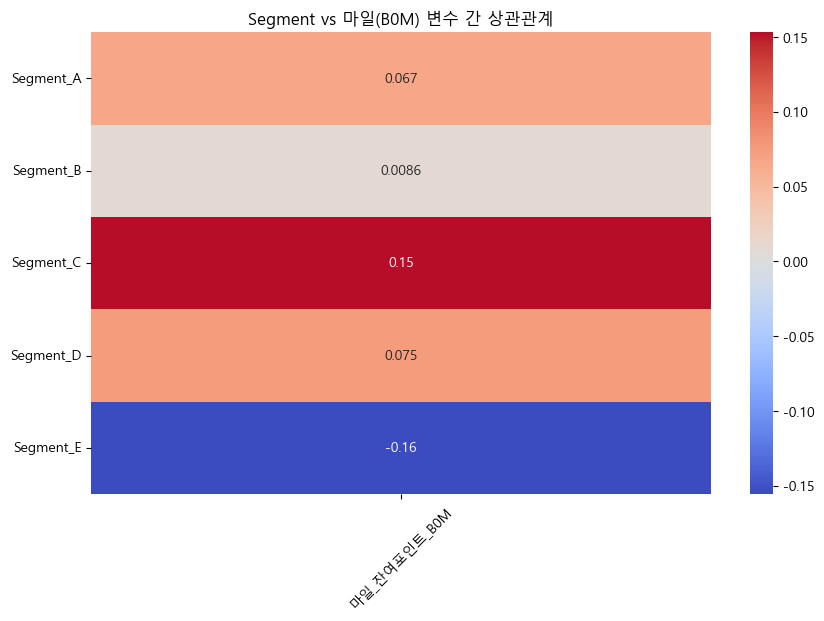

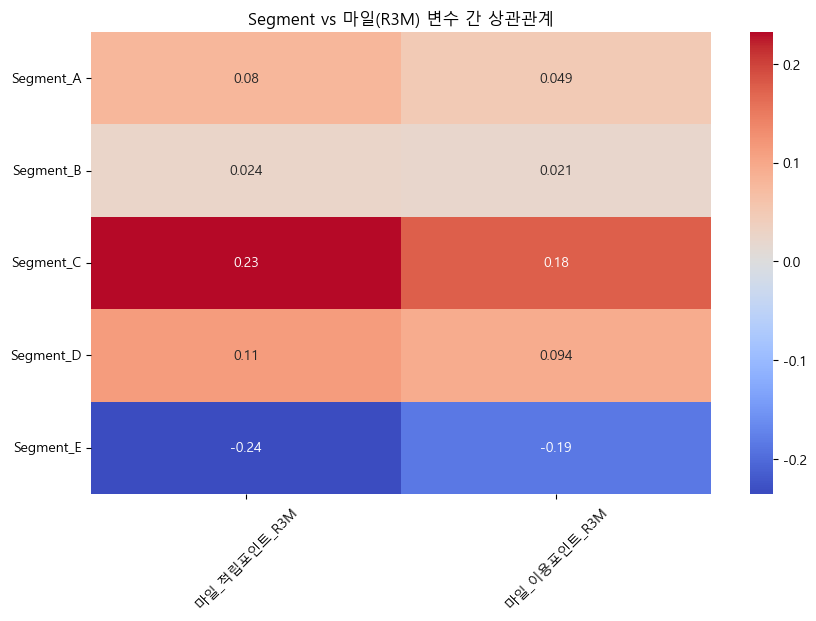

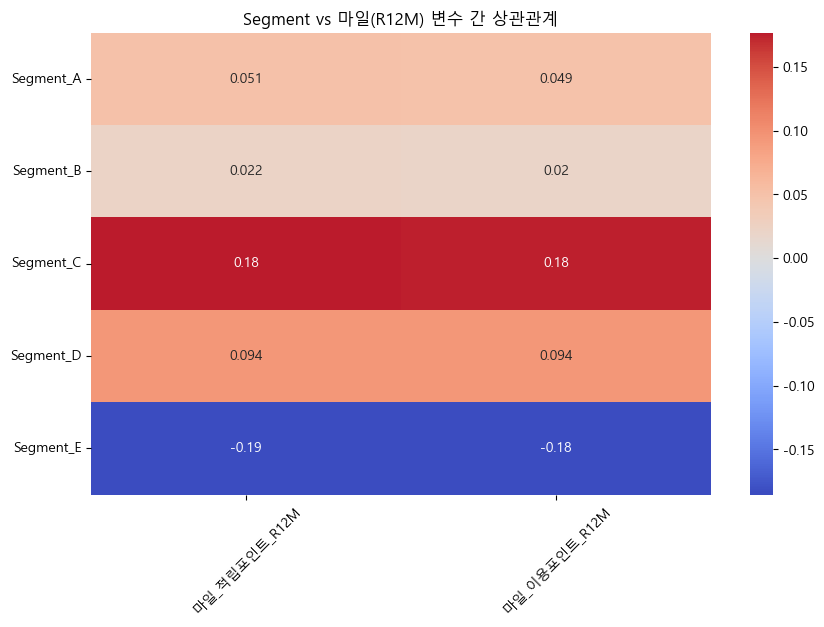

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_heatmap(df, cols, title):
    # 더미 인코딩
    df_dummy = pd.get_dummies(df[['Segment']], prefix='Segment')
    
    # 선택 컬럼 + 더미 결합
    df_all = pd.concat([df_dummy, df[cols]], axis=1)

    # 상관관계
    corr = df_all.corr().loc[df_dummy.columns, cols]

    # 시각화
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# B0M 상관관계 히트맵
plot_corr_heatmap(bill_df_with_segment, mile_b0m_cols, "Segment vs 마일(B0M) 변수 간 상관관계")

# R3M 상관관계 히트맵
plot_corr_heatmap(bill_df_with_segment, mile_r3m_cols, "Segment vs 마일(R3M) 변수 간 상관관계")

# R12M 상관관계 히트맵
plot_corr_heatmap(bill_df_with_segment, mile_r12m_cols, "Segment vs 마일(R12M) 변수 간 상관관계")

## 📌 마일리지 관련 변수 유의성 판단

### ✅ 1. Segment별 마일(B0M) 평균

| Segment | A     | B     | C     | D     | E     |
|---------|-------|-------|-------|-------|-------|
| 마일_잔여포인트_B0M | 355.93 | 129.76 | 82.06  | 34.73  | 8.38   |

➡️ Segment A, B는 당월 기준으로 잔여 포인트가 상대적으로 높음. 세그먼트 구분에 활용 가능성이 있음.

---

### ✅ 2. Segment별 마일(R3M) 평균

| Segment | A     | B     | C     | D     | E     |
|---------|-------|-------|-------|-------|-------|
| 마일_적립포인트_R3M | 2915.16 | 2302.03 | 831.91 | 340.50 | 65.24 |
| 마일_이용포인트_R3M | 1561.00 | 1722.78 | 548.58 | 235.63 | 42.95 |

➡️ A, B 세그먼트의 활동성이 높고, E는 확실히 낮아 분류 기준으로 의미 있음.

---

### ✅ 3. Segment별 마일(R12M) 평균

| Segment | A     | B     | C     | D     | E     |
|---------|-------|-------|-------|-------|-------|
| 마일_적립포인트_R12M | 7321.65 | 8316.01 | 2479.75 | 1061.86 | 185.92 |
| 마일_이용포인트_R12M | 7364.51 | 8026.26 | 2592.59 | 1129.14 | 216.14 |

➡️ 장기 누적 데이터로 봤을 때도 B > A > C > D > E 경향 유지됨. 안정적인 구분 지표 가능성 높음.

---

### 💡 종합 판단

- 📈 **B0M, R3M, R12M 모두 세그먼트 구분력 뚜렷**  
- ❗ 하지만 변수 간 유사 경향을 보임 → 다중공선성(VIF) 문제 가능성 있음

---

### ✅ 결론: 변수 유지 여부

- 현재는 **모든 변수를 유지**하는 것이 타당함.
- 모델링 단계에서 **VIF 계수**를 활용해 제거 여부 판단 예정.
- **PCA**, **변수 선택 알고리즘 (RFE 등)** 고려할 수 있음.

C:\Users\ska12\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


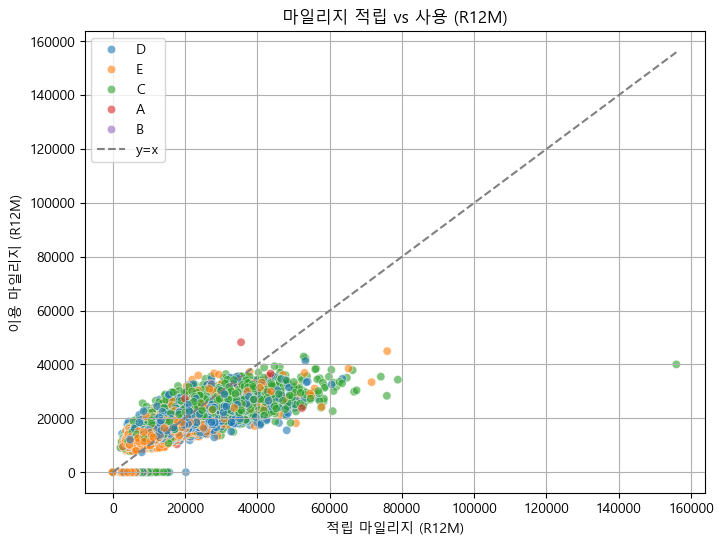

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Segment A~E 필터링
df_seg = bill_df_with_segment[bill_df_with_segment['Segment'].isin(['A', 'B', 'C', 'D', 'E'])]

# 산점도: 적립 vs 사용
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_seg, 
    x='마일_적립포인트_R12M', 
    y='마일_이용포인트_R12M', 
    hue='Segment', 
    alpha=0.6
)
plt.plot([0, df_seg['마일_적립포인트_R12M'].max()], 
         [0, df_seg['마일_적립포인트_R12M'].max()], 
         linestyle='--', color='gray', label='y=x')

plt.title("마일리지 적립 vs 사용 (R12M)")
plt.xlabel("적립 마일리지 (R12M)")
plt.ylabel("이용 마일리지 (R12M)")
plt.legend()
plt.grid(True)
plt.show()

## 🔍 변수 유지 여부 판단: 마일리지 적립/사용 (R12M)

### 🎯 분석 목적: 고객 세그먼트 분류

### 📌 분석 결과 요약
- 적립과 사용 간의 뚜렷한 차이는 있으나,
- Segment 간 경계가 명확하지 않음 (시각화에서도 구분 어려움)
- 대부분 Segment C가 중심 → **편향된 분포**

### ✅ 판단
- **세그먼트 분류 목적**에선 **예측력 기여도 낮음**
- 해당 변수는 **소비패턴 분석**에는 의미 있으나,
- **분류 모델 입력 변수로서 효과는 낮을 것으로 판단됨**

---

### 🗑️ 결론: **모델링에서는 제거해도 무방**

> 단, EDA나 향후 마케팅 전략 수립용 분석에는 보조지표로 참고 가능함

C:\Users\ska12\AppData\Local\Temp\ipykernel_28068\2536036082.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\ska12\AppData\Local\Temp\ipykernel_28068\2536036082.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\ska12\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ska12\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


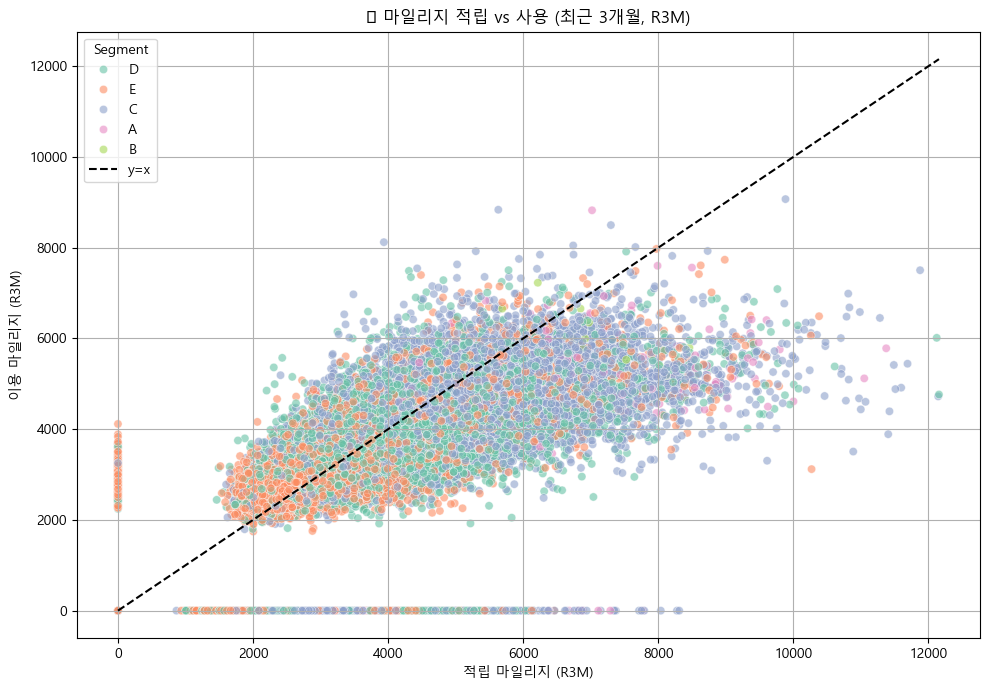

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=bill_df_with_segment[bill_df_with_segment['Segment'].isin(['A','B','C','D','E'])],
    x="마일_적립포인트_R3M",
    y="마일_이용포인트_R3M",
    hue="Segment",
    alpha=0.6,
    palette="Set2"
)

# y = x 비교선
max_val = max(bill_df_with_segment["마일_적립포인트_R3M"].max(), 
              bill_df_with_segment["마일_이용포인트_R3M"].max())
plt.plot([0, max_val], [0, max_val], 'k--', label='y=x')

plt.title("📊 마일리지 적립 vs 사용 (최근 3개월, R3M)")
plt.xlabel("적립 마일리지 (R3M)")
plt.ylabel("이용 마일리지 (R3M)")
plt.legend(title="Segment")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 마일리지 적립 vs 사용 (R3M) 분석 요약

### 🔍 시각화 개요
- **X축**: 최근 3개월 적립 마일리지 (`마일_적립포인트_R3M`)
- **Y축**: 최근 3개월 이용 마일리지 (`마일_이용포인트_R3M`)
- **색상**: 고객 세그먼트 (`Segment`)
- **비교선**: `y = x` (적립 = 사용인 지점)

### 📌 주요 관찰 결과
- 대부분의 점들이 **y = x 아래**에 분포:  
  → **적립한 마일리지보다 사용한 마일리지가 적은 경향**.
- **Segment별 차별적인 패턴**은 명확하지 않음:  
  → 다섯 개의 Segment가 고르게 분포되어 있으며,  
    특정 Segment만이 두드러지는 양상을 보이진 않음.
- 일부 고객은 **적립 대비 과도하게 많은 마일리지 사용**,  
  또는 **적립은 있지만 전혀 사용하지 않음(=y=0 근처)**의 사례 존재.

### 🧩 해석 및 향후 방향
- **세그먼트 분류를 위한 변수로서 결정적인 역할을 하기는 어려워 보임**.
- 하지만 마일리지 이용 행태 분석에는 활용 가능성이 있음.
- **당장은 보류 변수로 관리**, 향후 모델링 시 **VIF나 중요도 기반 선별**을 통해 포함 여부 재평가 예정.

---


## ✅ 마일리지 관련 변수 요약 정리

### 📌 분석 결과 요약
- `Segment`별 평균 비교에서는 마일리지 적립/이용 변수들이 **뚜렷한 차이를 보이며 그룹을 나눠주는 역할**을 함.
- 하지만 `마일_적립포인트` vs `마일_이용포인트`의 **산점도 분석(R12M, R3M)** 결과:
  - 전체적으로 `y = x` 아래에 분포해 **적립 > 사용** 경향이 강함.
  - 다만 **Segment 간 분포 패턴의 명확한 차별성은 관찰되지 않음**.
  - 따라서 분류 목적의 변수로서는 **정보력이 다소 떨어지는 모습**.

### 🧭 결론 및 향후 방향
- 상관 분석 상 `Segment`와의 관계는 있으므로 **당장 제거하지 않고 보류**.
- 추후 모델링 단계에서 **VIF, 변수 중요도, 다중공선성 등을 기준으로 제거 여부 최종 판단**.


In [50]:
bill_df_with_segment['Segment'].value_counts()

Segment
E    1922052
D     349242
C     127590
A        972
B        144
Name: count, dtype: int64

In [54]:
# 세그먼트 비율 계산
segment_ratio = bill_df_with_segment['Segment'].value_counts(normalize=True)

# 결과 보기
print(segment_ratio * 100)

Segment
E    80.08550
D    14.55175
C     5.31625
A     0.04050
B     0.00600
Name: proportion, dtype: float64


C:\Users\ska12\AppData\Local\Temp\ipykernel_28068\2879316475.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=144, random_state=42) if len(x) >= 144 else x)


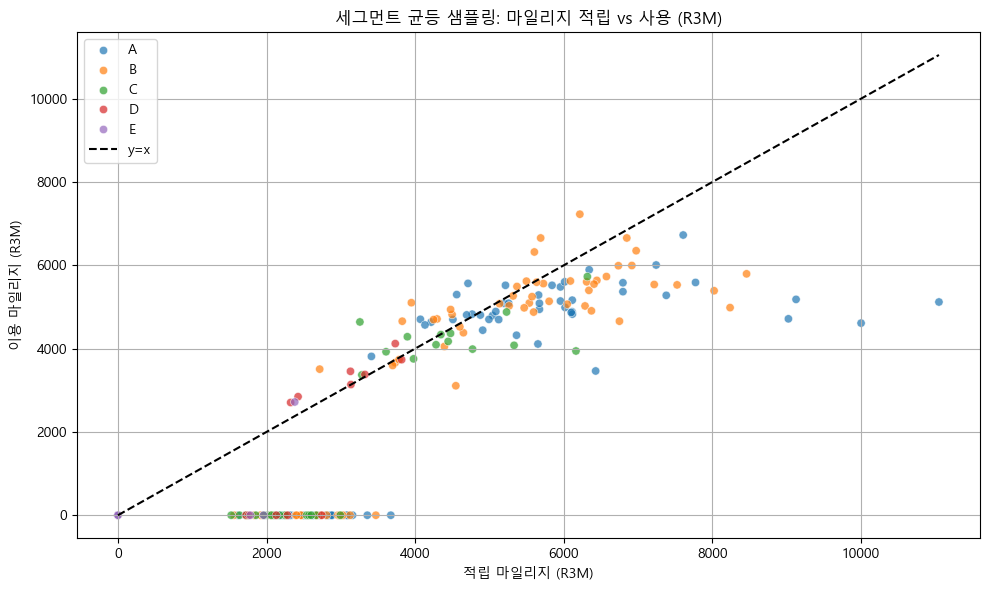

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 필요한 컬럼만 선택
cols = ['마일_적립포인트_R3M', '마일_이용포인트_R3M', 'Segment']

# 144개 기준으로 세그먼트별 샘플링
sampled_df = (
    bill_df_with_segment[cols]
    .groupby('Segment', group_keys=False)
    .apply(lambda x: x.sample(n=144, random_state=42) if len(x) >= 144 else x)
    .reset_index(drop=True)
)

# 산점도 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sampled_df,
    x='마일_적립포인트_R3M',
    y='마일_이용포인트_R3M',
    hue='Segment',
    alpha=0.7
)

# y = x 기준선 추가
max_val = max(sampled_df['마일_적립포인트_R3M'].max(), sampled_df['마일_이용포인트_R3M'].max())
plt.plot([0, max_val], [0, max_val], 'k--', label='y=x')

plt.title('세그먼트 균등 샘플링: 마일리지 적립 vs 사용 (R3M)')
plt.xlabel('적립 마일리지 (R3M)')
plt.ylabel('이용 마일리지 (R3M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 📈 시각화 관찰 결과
- **전반적으로 적립량이 사용량보다 높음** (y = x 아래쪽에 분포)
- 일부 `A 세그먼트`의 경우, **적립량이 특히 높은 경향**이 있음 → X축 오른쪽으로 치우침
- 세그먼트 간 분류 경계가 명확하진 않음
- 분류 예측에 큰 기여를 하진 않으나, 소비패턴 차이를 보여줄 수 있는 지표

### ✅ 마일_잔여포인트_B0M 변수 해석 및 활용 가능성

- 📌 **A, B 세그먼트의 당월 잔여 마일리지 평균이 높게 나타남**
- ✅ `마일_적립포인트` 평균도 A, B 세그먼트에서 높았기 때문에,
  - 이는 **단순히 적게 소비한 게 아니라, 소비는 많았으나 마일리지 사용이 제한적이었을 가능성**이 있음
  - 즉, **1. 평소 소비를 많이 했지만 사용처가 제한적이라 마일리지를 많이 사용하지 못한 고객**에 해당

- 🎯 따라서 이 변수는 다른 마일리지 관련 컬럼들이 제거되더라도,  
  **마일리지 소비 패턴과 잔여량의 특성을 반영하여 세그먼트 분류에 기여할 수 있는 변수**로 판단됨

- 📌 **결론: `마일_잔여포인트_B0M`은 유지하는 것이 바람직**


C:\Users\ska12\AppData\Local\Temp\ipykernel_28068\476153695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=bill_df_with_segment[bill_df_with_segment['Segment'].isin(['A', 'B', 'C', 'D', 'E'])],


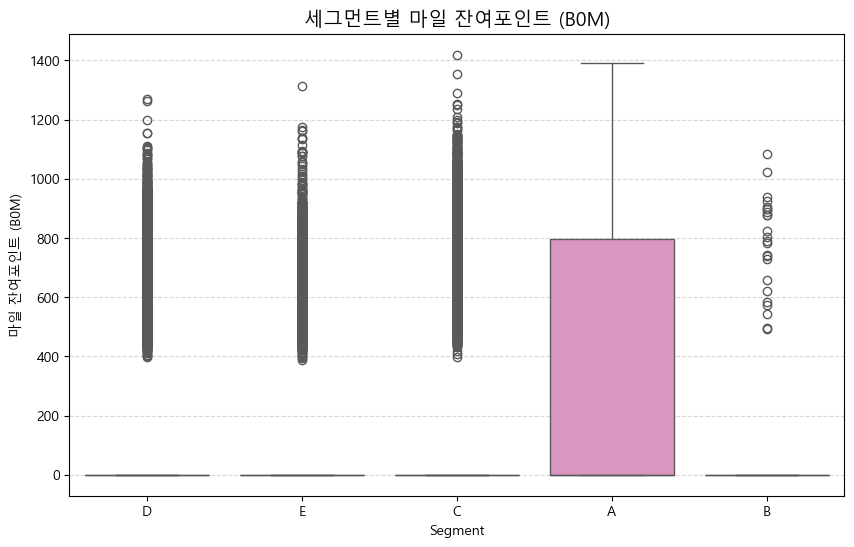

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=bill_df_with_segment[bill_df_with_segment['Segment'].isin(['A', 'B', 'C', 'D', 'E'])],
            x='Segment',
            y='마일_잔여포인트_B0M',
            palette='Set2')

plt.title('세그먼트별 마일 잔여포인트 (B0M)', fontsize=14)
plt.ylabel('마일 잔여포인트 (B0M)')
plt.xlabel('Segment')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

- `마일_잔여포인트_B0M`은 Segment A (그리고 일부 B)에서 압도적으로 높은 값을 가짐.
- 이는 A 고객군이 마일리지를 **많이 적립했지만 사용하지 않았거나**, **큰 소비를 했지만 사용처가 제한적이었을 가능성**을 시사함.
- 따라서 이 변수는 다른 마일리지 변수들과는 다르게, **Segment A와 나머지를 구분하는 중요한 지표가 될 수 있음**.
- 다른 마일리지 변수들이 제거된다 하더라도, 이 변수는 **세그먼트 분류에 잔존시킬 가능성이 높음**.
